Iñigo Martin Melero

## Participante 12

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_12_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


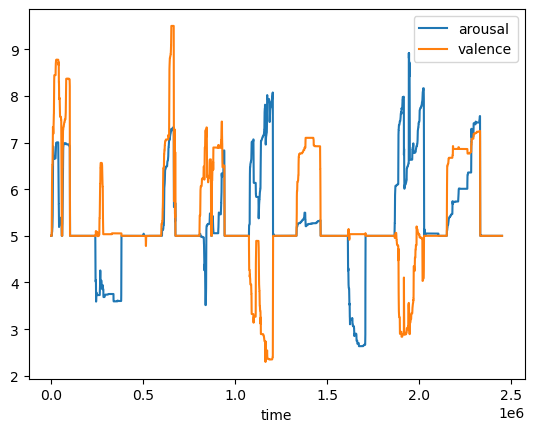

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_12_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.912  37.020  21.519  42.032  28.380     7.452     9.259   
1              1  0.882  37.049  21.613  42.013  28.376     7.288     9.177   
2              2  0.853  37.078  21.708  41.994  28.373     7.124     9.095   
3              3  0.823  37.107  21.803  41.974  28.369     6.960     9.013   
4              4  0.846  37.252  21.637  41.994  28.376     7.083     9.177   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.784  36.226  31.975  41.345  24.580     6.672     6.919   
2451580  2451580  0.793  36.390  32.038  41.374  24.580     6.672     6.919   
2451581  2451581  0.793  36.477  31.860  41.355  24.580     6.672     6.960   
2451582  2451582  0.780  36.361  31.959  41.345  24.576     6.713     6.837   
2451583  2451583  0.790  36.342  31.844  41.355  24.580     6.754     6.960   

         emg_trap  video  
0          12.380     10

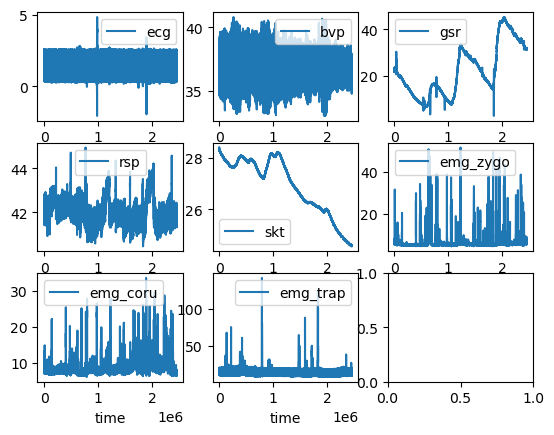

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

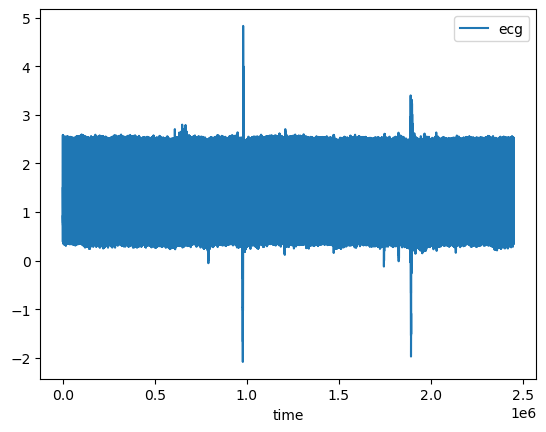

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

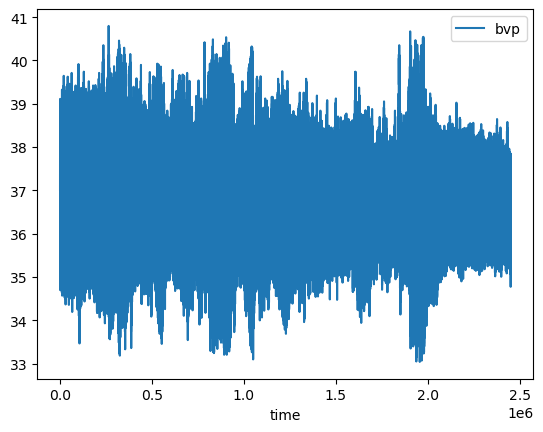

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

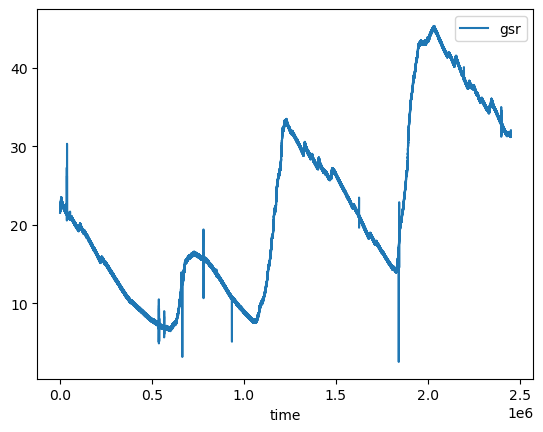

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

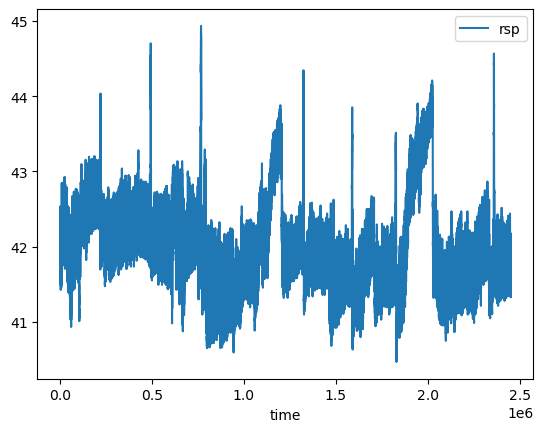

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

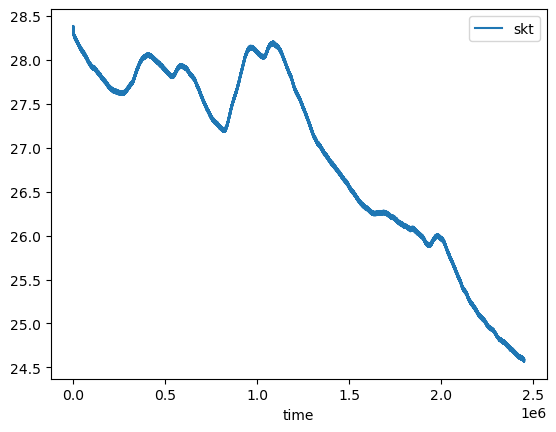

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

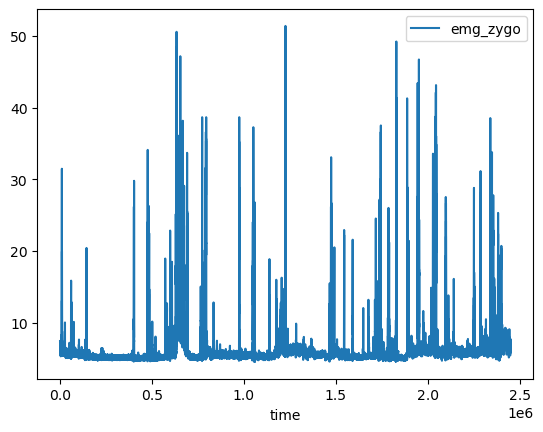

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

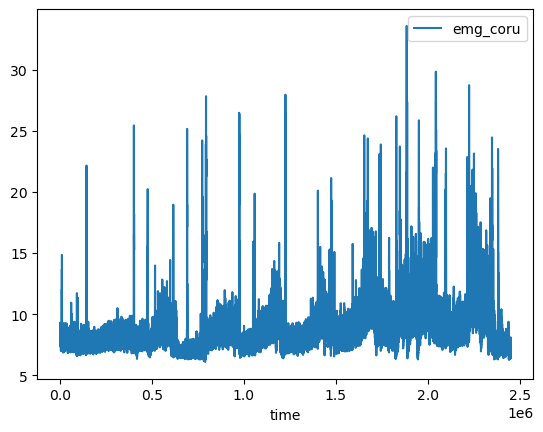

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

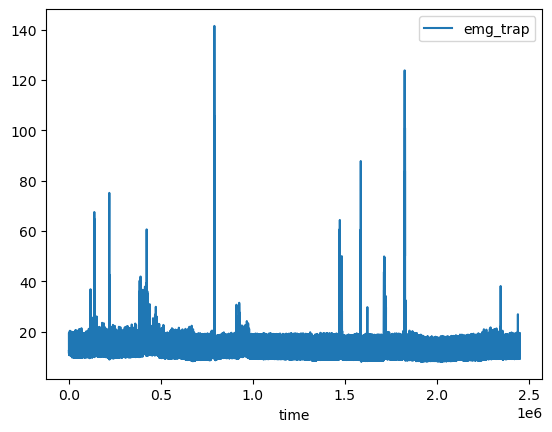

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

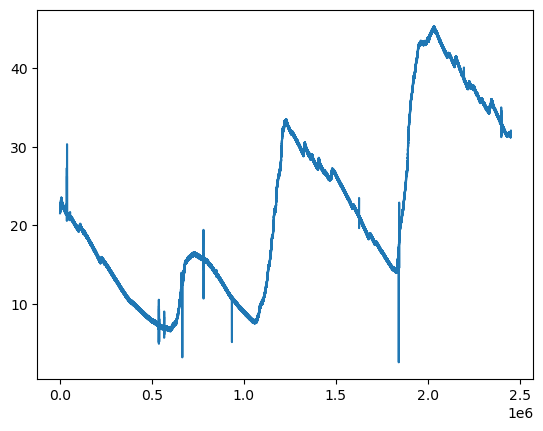

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

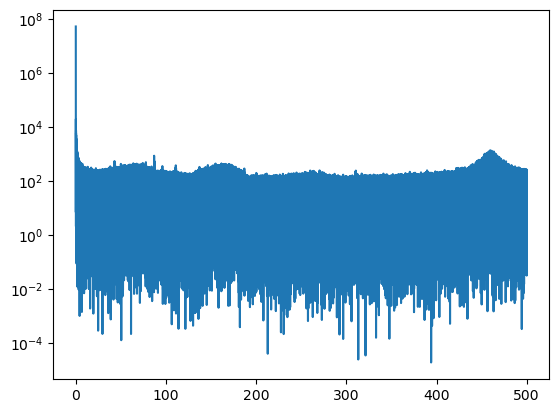

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

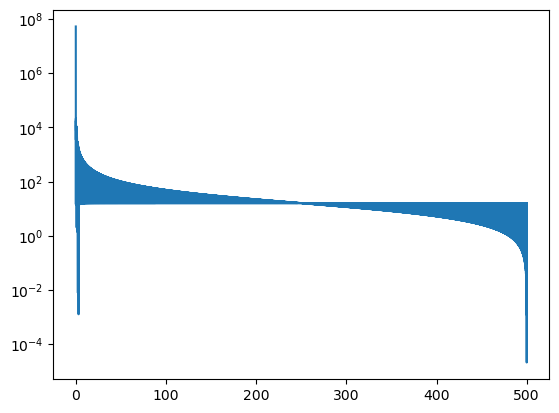

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

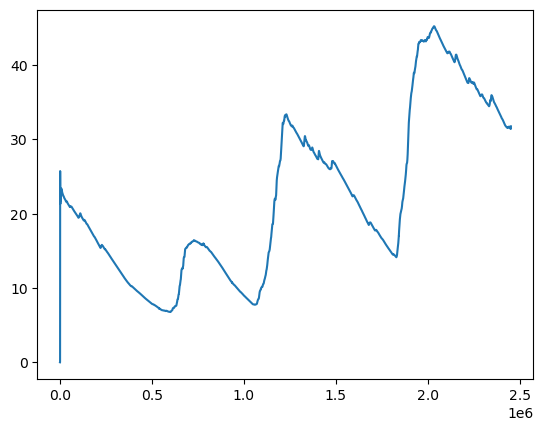

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  31.716
2451580  31.716
2451581  31.716
2451582  31.717
2451583  31.717

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

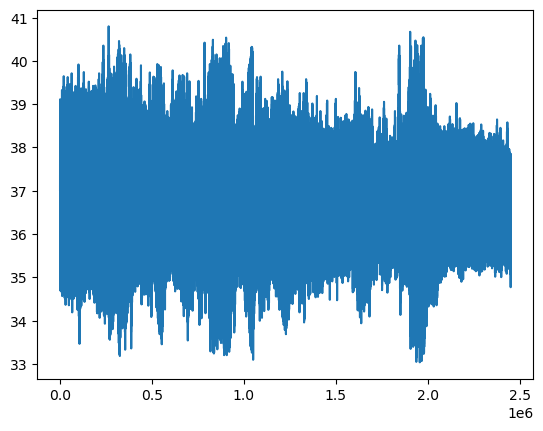

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

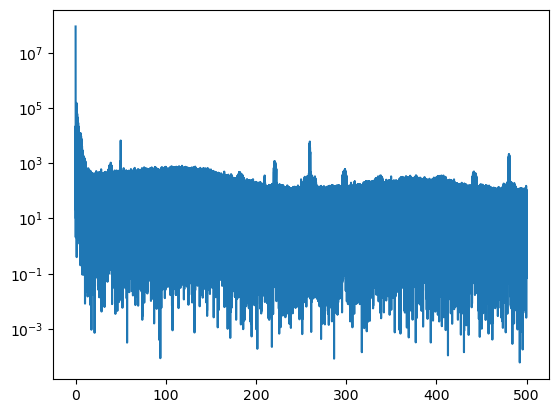

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

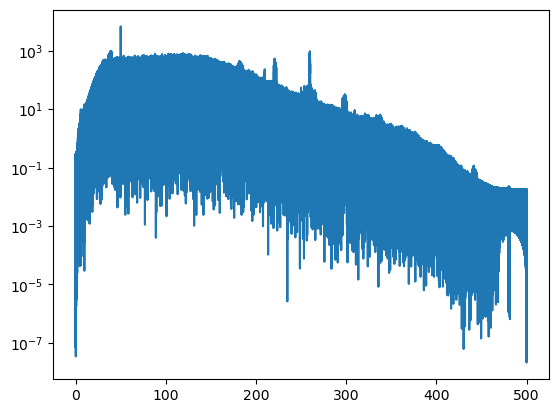

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

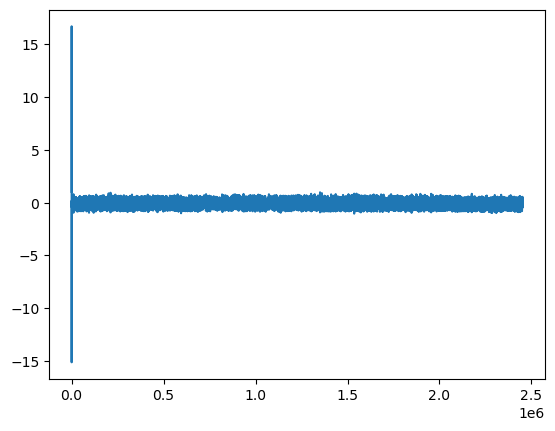

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.029
1        42.739
2        50.507
3        53.710
4        46.370
...         ...
2451579  37.014
2451580  36.991
2451581  36.903
2451582  36.847
2451583  36.905

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

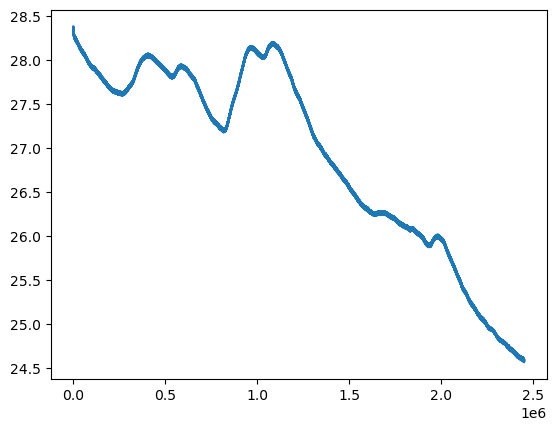

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

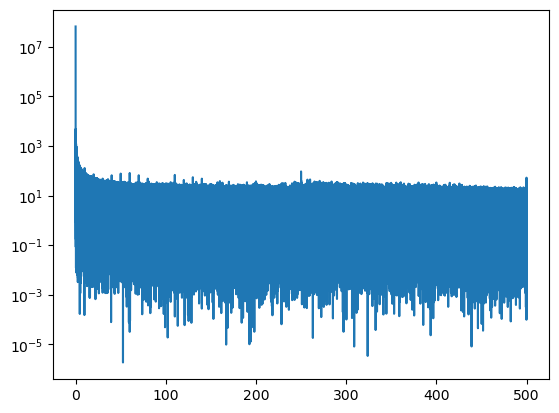

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

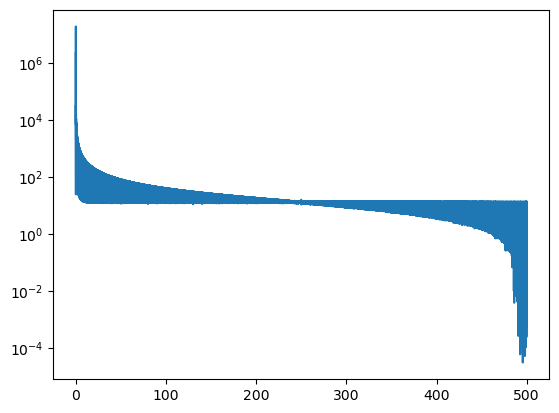

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

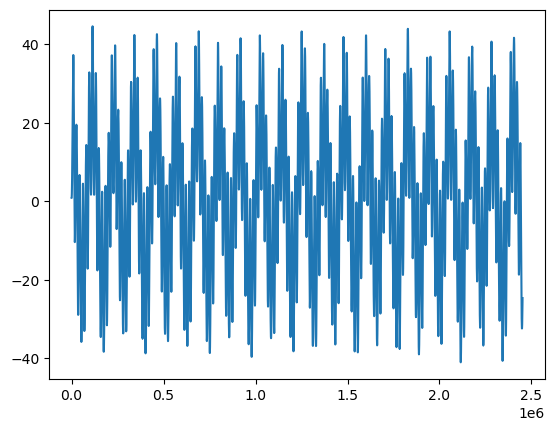

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.909
1        40.909
2        40.909
3        40.909
4        40.909
...         ...
2451579  15.381
2451580  15.386
2451581  15.390
2451582  15.395
2451583  15.399

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.912  42.032     7.452     9.259    12.380     10
1              1  0.882  42.013     7.288     9.177    12.216     10
2              2  0.853  41.994     7.124     9.095    12.052     10
3              3  0.823  41.974     6.960     9.013    11.888     10
4              4  0.846  41.994     7.083     9.177    12.011     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.784  41.345     6.672     6.919     9.588     12
2451580  2451580  0.793  41.374     6.672     6.919     9.588     12
2451581  2451581  0.793  41.355     6.672     6.960     9.629     12
2451582  2451582  0.780  41.345     6.713     6.837     9.506     12
2451583  2451583  0.790  41.355     6.754     6.960     9.588     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.912  42.032     7.452     9.259    12.380     10  38.029   
1              1  0.882  42.013     7.288     9.177    12.216     10  42.739   
2              2  0.853  41.994     7.124     9.095    12.052     10  50.507   
3              3  0.823  41.974     6.960     9.013    11.888     10  53.710   
4              4  0.846  41.994     7.083     9.177    12.011     10  46.370   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.784  41.345     6.672     6.919     9.588     12  37.014   
2451580  2451580  0.793  41.374     6.672     6.919     9.588     12  36.991   
2451581  2451581  0.793  41.355     6.672     6.960     9.629     12  36.903   
2451582  2451582  0.780  41.345     6.713     6.837     9.506     12  36.847   
2451583  2451583  0.790  41.355     6.754     6.960     9.588     12  36.905   

            gsr     skt  
0         0.000  40.909  
1         0.000  40.909  
2         0.000  40.909  
3         0.000  40.909  
4         0.000  40.909  
...         ...     ...  
2451579  31.716  15.381  
2451580  31.716  15.386  
2451581  31.716  15.390  
2451582  31.717  15.395  
2451583  31.717  15.399  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.506053  0.520645  0.228050  0.793731  0.369728  0.014284   
221502    221502  0.509220  0.497482  0.228050  0.793658  0.392952  0.014284   
221503    221503  0.507357  0.475327  0.228050  0.793584  0.361986  0.010697   
221504    221504  0.511082  0.493958  0.228050  0.793498  0.364389  0.012501   
221505    221505  0.508661  0.518630  0.228050  0.793424  0.364389  0.013392   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.503073  0.510574  0.726476  0.356196  0.312867  0.027676   
2331580  2331580  0.502514  0.517623  0.726476  0.356282  0.312867  0.027676   
2331581  2331581  0.501211  0.532729  0.726476  0.356356  0.312867  0.026785   
2331582  2331582  0.501211  0.513595  0.726476  0.356442  0.310198  0.027676   
2331583  2331583  0.501769  0.486405  0.726476  0.356528  0.320609  0.028568   

         emg_coru  emg_trap  video  
221501   0.055739  0.126296      4  
221502   0.055739  0.127977      4  
221503   0.054235  0.119533      4  
221504   0.055739  0.124575      4  
221505   0.057242  0.119533      4  
...           ...       ...    ...  
2331579  0.126513  0.097643      1  
2331580  0.126513  0.099324      1  
2331581  0.128016  0.101004      1  
2331582  0.132527  0.104407      1  
2331583  0.135570  0.107768      1  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.506053  0.520645  0.228050  0.369728  0.793731  0.014284   
221502    221502  0.509220  0.497482  0.228050  0.392952  0.793658  0.014284   
221503    221503  0.507357  0.475327  0.228050  0.361986  0.793584  0.010697   
221504    221504  0.511082  0.493958  0.228050  0.364389  0.793498  0.012501   
221505    221505  0.508661  0.518630  0.228050  0.364389  0.793424  0.013392   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.503073  0.510574  0.726476  0.312867  0.356196  0.027676   
2331580  2331580  0.502514  0.517623  0.726476  0.312867  0.356282  0.027676   
2331581  2331581  0.501211  0.532729  0.726476  0.312867  0.356356  0.026785   
2331582  2331582  0.501211  0.513595  0.726476  0.310198  0.356442  0.027676   
2331583  2331583  0.501769  0.486405  0.726476  0.320609  0.356528  0.028568   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
221540   0.503073  0.502518  0.228182  0.361986  0.790756  0.013392  0.049725   
221560   0.501211  0.494965  0.228234  0.374800  0.789219  0.015175  0.060249   
221580   0.501211  0.539778  0.228313  0.364389  0.787682  0.013392  0.066263   
221600   0.498231  0.522155  0.228391  0.372130  0.786145  0.015175  0.057242   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.500652  0.545821  0.726607  0.310198  0.349654  0.031242  0.099413   
2331520  0.501211  0.528197  0.726555  0.312867  0.351314  0.030350  0.073817   
2331540  0.503632  0.524169  0.726528  0.312867  0.352974  0.030350  0.094903   
2331560  0.503632  0.478348  0.726502  0.315270  0.354622  0.031242  0.084342   
2331580  0.502514  0.517623  0.726476  0.312867  0.356282  0.027676  0.126513   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1      0.503073  0.502518  0.228182  0.361986  0.790756  0.013392  0.049725   
2      0.501211  0.494965  0.228234  0.374800  0.789219  0.015175  0.060249   
3      0.501211  0.539778  0.228313  0.364389  0.787682  0.013392  0.066263   
4      0.498231  0.522155  0.228391  0.372130  0.786145  0.015175  0.057242   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.500652  0.545821  0.726607  0.310198  0.349654  0.031242  0.099413   
63500  0.501211  0.528197  0.726555  0.312867  0.351314  0.030350  0.073817   
63501  0.503632  0.524169  0.726528  0.312867  0.352974  0.030350  0.094903   
63502  0.503632  0.478348  0.726502  0.315270  0.354622  0.031242  0.084342   
63503  0.502514  0.517623  0.726476  0.312867  0.356282  0.027676  0.126513   

       emg_trap  valence  arousal  
0      0.112810     5.00    5.000  
1      0.245788     5.00    5.000  
2      0.205411     5.00    5.000  
3      0.141422     5.00    5.000  
4      0.095962     5.00    5.000  
...         ...      ...      ...  
63499  0.085878     7.25    7.567  
63500  0.072392     7.25    7.567  
63501  0.080836     7.25    7.568  
63502  0.090920     7.25    7.569  
63503  0.099324     7.25    7.568  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1      0.503073  0.502518  0.228182  0.361986  0.790756  0.013392  0.049725   
2      0.501211  0.494965  0.228234  0.374800  0.789219  0.015175  0.060249   
3      0.501211  0.539778  0.228313  0.364389  0.787682  0.013392  0.066263   
4      0.498231  0.522155  0.228391  0.372130  0.786145  0.015175  0.057242   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.500093  0.521652  0.726738  0.312867  0.343015  0.033916  0.126513   
63496  0.500093  0.482377  0.726712  0.315270  0.344687  0.031242  0.134030   
63497  0.501211  0.481873  0.726660  0.312867  0.346347  0.026785  0.171691   
63498  0.504377  0.481370  0.726633  0.315270  0.347994  0.031242  0.143088   
63499  0.500652  0.545821  0.726607  0.310198  0.349654  0.031242  0.099413   

       emg_trap  valence  arousal  
0      0.112810     5.00    5.000  
1      0.245788     5.00    5.000  
2      0.205411     5.00    5.000  
3      0.141422     5.00    5.000  
4      0.095962     5.00    5.000  
...         ...      ...      ...  
63495  0.085878     7.25    7.567  
63496  0.082517     7.25    7.568  
63497  0.082517     7.25    7.569  
63498  0.106087     7.25    7.568  
63499  0.085878     7.25    7.567  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
 1   0.503073  0.502518  0.228182  0.361986  0.790756  0.013392  0.049725   
 2   0.501211  0.494965  0.228234  0.374800  0.789219  0.015175  0.060249   
 3   0.501211  0.539778  0.228313  0.364389  0.787682  0.013392  0.066263   
 4   0.498231  0.522155  0.228391  0.372130  0.786145  0.015175  0.057242   
 5   0.496368  0.484894  0.228444  0.372130  0.784608  0.013392  0.048221   
 6   0.499348  0.505035  0.228523  0.385211  0.783071  0.014284  0.052732   
 7   0.497486  0.466767  0.228601  0.377469  0.781521  0.011610  0.048221   
 8   0.493947  0.467774  0.228654  0.369728  0.779972  0.009827  0.046681   
 9   0.497486  0.533233  0.228733  0.377469  0.778435  0.010697  0.055739   
 10  0.491525  0.517623  0.228811  0.377469  0.776873  0.009827  0.051228   
 11  0.495064  0.469285  0.228864  0.377469  0.775324  0.008914  0.046681   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1     0.427826  0.496475  0.229467  0.377469  0.753486  0.008022  0.051228   
2     0.502514  0.470796  0.230648  0.390283  0.714458  0.014284  0.048221   
3     0.484075  0.513092  0.231776  0.374800  0.676512  0.013392  0.064796   
4     0.503632  0.481873  0.232564  0.369728  0.640779  0.013392  0.060249   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.498231  0.495972  0.729152  0.315270  0.165556  0.042852  0.051228   
2536  0.613895  0.502014  0.728864  0.465296  0.195571  0.030350  0.024129   
2537  0.513503  0.511078  0.728496  0.524560  0.230381  0.052678  0.046681   
2538  0.503632  0.527694  0.727919  0.354245  0.268893  0.056244  0.045178   
2539  0.530639  0.510070  0.727211  0.325681  0.309716  0.033025  0.105427   

             8         9        10  ...       193       194       195  \
0     0.112810  0.503073  0.502518  ...  0.772956  0.474824  0.229441   
1     0.388891  0.496368  0.505539  ...  0.504936  0.482377  0.230596   
2     0.127977  0.498789  0.519637  ...  0.483516  0.479355  0.231750   
3     0.222218  0.489663  0.532729  ...  0.500093  0.462236  0.232537   
4     0.210453  0.506053  0.569990  ...  0.511641  0.522659  0.233167   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.074073  0.496368  0.517623  ...  0.493947  0.528701  0.728890   
2536  0.082517  0.814491  0.476838  ...  0.509778  0.396274  0.728523   
2537  0.089240  0.512200  0.485398  ...  0.509220  0.493958  0.727919   
2538  0.075794  0.498789  0.433535  ...  0.574595  0.436556  0.727237   
2539  0.097643  0.511082  0.521652  ...  0.500652  0.545821  0.726607   

           196       197       198       199       200  valence  arousal  
0     0.387613  0.755048  0.013392  0.069307  0.223939  5.00000  5.00000  
1     0.379872  0.716007  0.016067  0.057242  0.139742  5.00000  5.00000  
2     0.387613  0.678000  0.016067  0.052732  0.117852  5.00000  5.00000  
3     0.367058  0.642156  0.011610  0.063256  0.188563  5.00000  5.00000  
4     0.498932  0.609387  0.014284  0.042171  0.116171  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.452216  0.194280  0.032133  0.031646  0.082517  7.23224  7.47252  
2536  0.527229  0.228906  0.057135  0.043711  0.074073  7.24916  7.52144  
2537  0.356647  0.267295  0.055353  0.042171  0.069031  7.25000  7.54412  
2538  0.325681  0.308069  0.035699  0.138577  0.101004  7.25000  7.56788  
2539  0.310198  0.349654  0.031242  0.099413  0.085878  7.25000  7.56796  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1     0.427826  0.496475  0.229467  0.377469  0.753486  0.008022  0.051228   
2     0.502514  0.470796  0.230648  0.390283  0.714458  0.014284  0.048221   
3     0.484075  0.513092  0.231776  0.374800  0.676512  0.013392  0.064796   
4     0.503632  0.481873  0.232564  0.369728  0.640779  0.013392  0.060249   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.498231  0.495972  0.729152  0.315270  0.165556  0.042852  0.051228   
2536  0.613895  0.502014  0.728864  0.465296  0.195571  0.030350  0.024129   
2537  0.513503  0.511078  0.728496  0.524560  0.230381  0.052678  0.046681   
2538  0.503632  0.527694  0.727919  0.354245  0.268893  0.056244  0.045178   
2539  0.530639  0.510070  0.727211  0.325681  0.309716  0.033025  0.105427   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub12.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1     0.427826  0.496475  0.229467  0.377469  0.753486  0.008022  0.051228   
2     0.502514  0.470796  0.230648  0.390283  0.714458  0.014284  0.048221   
3     0.484075  0.513092  0.231776  0.374800  0.676512  0.013392  0.064796   
4     0.503632  0.481873  0.232564  0.369728  0.640779  0.013392  0.060249   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.498231  0.495972  0.729152  0.315270  0.165556  0.042852  0.051228   
2536  0.613895  0.502014  0.728864  0.465296  0.195571  0.030350  0.024129   
2537  0.513503  0.511078  0.728496  0.524560  0.230381  0.052678  0.046681   
2538  0.503632  0.527694  0.727919  0.354245  0.268893  0.056244  0.045178   
2539  0.530639  0.510070  0.727211  0.325681  0.309716  0.033025  0.105427   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub12.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1     0.427826  0.496475  0.229467  0.377469  0.753486  0.008022  0.051228   
2     0.502514  0.470796  0.230648  0.390283  0.714458  0.014284  0.048221   
3     0.484075  0.513092  0.231776  0.374800  0.676512  0.013392  0.064796   
4     0.503632  0.481873  0.232564  0.369728  0.640779  0.013392  0.060249   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.498231  0.495972  0.729152  0.315270  0.165556  0.042852  0.051228   
2536  0.613895  0.502014  0.728864  0.465296  0.195571  0.030350  0.024129   
2537  0.513503  0.511078  0.728496  0.524560  0.230381  0.052678  0.046681   
2538  0.503632  0.527694  0.727919  0.354245  0.268893  0.056244  0.045178   
2539  0.530639  0.510070  0.727211  0.325681  0.309716  0.033025  0.105427   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub12.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1     0.427826  0.496475  0.229467  0.377469  0.753486  0.008022  0.051228   
2     0.502514  0.470796  0.230648  0.390283  0.714458  0.014284  0.048221   
3     0.484075  0.513092  0.231776  0.374800  0.676512  0.013392  0.064796   
4     0.503632  0.481873  0.232564  0.369728  0.640779  0.013392  0.060249   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.498231  0.495972  0.729152  0.315270  0.165556  0.042852  0.051228   
2536  0.613895  0.502014  0.728864  0.465296  0.195571  0.030350  0.024129   
2537  0.513503  0.511078  0.728496  0.524560  0.230381  0.052678  0.046681   
2538  0.503632  0.527694  0.727919  0.354245  0.268893  0.056244  0.045178   
2539  0.530639  0.510070  0.727211  0.325681  0.309716  0.033025  0.105427   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub12.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.504377  0.490937  0.228103  0.367058  0.792280  0.012501  0.060249   
1     0.427826  0.496475  0.229467  0.377469  0.753486  0.008022  0.051228   
2     0.502514  0.470796  0.230648  0.390283  0.714458  0.014284  0.048221   
3     0.484075  0.513092  0.231776  0.374800  0.676512  0.013392  0.064796   
4     0.503632  0.481873  0.232564  0.369728  0.640779  0.013392  0.060249   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.498231  0.495972  0.729152  0.315270  0.165556  0.042852  0.051228   
2536  0.613895  0.502014  0.728864  0.465296  0.195571  0.030350  0.024129   
2537  0.513503  0.511078  0.728496  0.524560  0.230381  0.052678  0.046681   
2538  0.503632  0.527694  0.727919  0.354245  0.268893  0.056244  0.045178   
2539  0.530639  0.510070  0.727211  0.325681  0.309716  0.033025  0.105427   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub12.csv', index=False)